In [2]:
import os
runner_path = "/home/alexmak123/neurone"
config_path = "/home/alexmak123/neurone/configs/endometritis.json"
weigths_path = "/home/alexmak123/neurone/experiments/endonet_v1/epoch_93.pth"
engine_type = "gpu"
device_number = 4
%cd $runner_path

if (engine_type == "gpu"):
    #here we choose on which tesla to run
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
    os.environ["CUDA_VISIBLE_DEVICES"] = str(device_number)
    !export 'PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512'

import argparse
import json
from animus.torch.engine import CPUEngine, DDPEngine, DPEngine, GPUEngine, XLAEngine
from neurone.utils.general import load_yaml
import torch
from datetime import datetime 
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from PIL import Image, ImageDraw
from skimage.io import imread, imsave, imshow
import cv2
%matplotlib inline

/home/alexmak123/neurone


In [3]:
#Download our tiles
tiles_directory_in_str = "/home/alexmak123/test_cappa_koef/plasmatic_tiles_anna/images"
%cd $tiles_directory_in_str

alb_transforms = A.Compose([A.augmentations.Resize(1024, 1024)])
def import_tiles_from_directory_and_convert_them (tiles_directory_in_str):
    directory = os.fsencode(tiles_directory_in_str)
    converted_images = []
    for file in os.listdir(directory):
        filename = os.fsdecode(file)
        if (filename.endswith(".png") or filename.endswith(".jpg")): 
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            converted_images.append(myTile)
            continue
        else:
            continue
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (tiles_directory_in_str)
print(converted_images.shape)

/home/alexmak123/test_cappa_koef/plasmatic_tiles_anna/images
(30, 1024, 1024, 3)


In [4]:
# Runners
from neurone.runners.detection import BaseDetectionRunner, HeatmapDetectionRunner
from neurone.runners.segmentation import BaseSegmentationRunner
from neurone.runners.gridsearch import GridSearchRunner


E2E = {
    "cpu": CPUEngine,
    "gpu": GPUEngine,
    "dp": DPEngine,
    "ddp": DDPEngine,
    "xla": XLAEngine,
}


with open(config_path, "r") as config_file:
        config = json.load(config_file)
config["train"]["engine"] = engine_type

if config["train"]["deterministic"]:
    torch.use_deterministic_algorithms(config["train"]["deterministic"])
logging_dir = os.path.join(config["train"]["save_dir"], config["train"]["experiment_name"])
    
runner = globals()[config["model"]["runner"]](engine=E2E[engine_type](
    log_with="tensorboard", logging_dir=logging_dir), config=config)

runner._setup_model()
runner.model.eval()


#if we have gpu, we should run on cuda
if (engine_type == "gpu"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    runner.model.to(device)

In [5]:
import sys
import time 

#our data to tensor
image_torch = torch.tensor(converted_images)
#image_torch = torch.unsqueeze(image_torch, 0)
image_torch = image_torch.permute(0, 3, 1, 2) 
image_torch = image_torch.float()
image_torch -= torch.tensor([config["data"]["norm_mean"][0], config["data"]["norm_mean"][1], config["data"]["norm_mean"][2]]).reshape(-1, 1, 1)
image_torch /= torch.tensor([config["data"]["norm_std"][0], config["data"]["norm_std"][1], config["data"]["norm_std"][2]]).reshape(-1, 1, 1)

if (engine_type == "cpu"):
    all_keypoints = runner.model(image_torch)["keypoints"]
    #all_confidences = runner.model(image_torch)["confidences"]

#amount of torch elements for a batch
#batch_size=2 is maximum for teslat4
batch_size = 2
if (engine_type == "gpu"):
    start = time.time() 
    all_keypoints = []
    #all_confidences = []
    splited_torch = torch.split(image_torch, batch_size)
    torch.cuda.empty_cache()
    i = 1
    num_iterations = int (image_torch.shape[0] / batch_size)
    
    for batch_torch in splited_torch:
        print ("iteration : ", i, "/", num_iterations)
        batch_torch = batch_torch.to(device)
        keypoint = np.array(runner.model(batch_torch)["keypoints"])
        all_keypoints.append(keypoint)
        #confidence = np.array(runner.model(batch_torch)["confidences"])
        #all_confidences.append(confidence) 
        i += 1
        del batch_torch
        
    end = time.time() - start
    print ("time, working on gpu", end)     

iteration :  1 / 15
iteration :  2 / 15
iteration :  3 / 15
iteration :  4 / 15
iteration :  5 / 15
iteration :  6 / 15
iteration :  7 / 15
iteration :  8 / 15
iteration :  9 / 15
iteration :  10 / 15
iteration :  11 / 15
iteration :  12 / 15
iteration :  13 / 15
iteration :  14 / 15
iteration :  15 / 15
time, working on gpu 27.707530975341797


In [6]:
#split keypoints of all tiles to array of selected colums with x_coords, y_coords and classes of all tiles
if (engine_type == "cpu"):
    j = 0
    selected_columns_array = []
    for index_tile in range(converted_images.shape[0]):
        selected_columns = []
        while (j < all_keypoints.shape[0] and all_keypoints[j][0] == index_tile):
            selected_columns.append([float(all_keypoints[j][1]), float(all_keypoints[j][2]), float(all_keypoints[j][3])])
            j += 1
        selected_columns_array.append(np.array(selected_columns))

if (engine_type == "gpu"):
    selected_columns_array = []
    for batch_keypoints in all_keypoints:
        j = 0
        for index_tile in range(batch_size):
            selected_columns = []
            while (j < batch_keypoints.shape[0] and batch_keypoints[j][0] == index_tile):
                selected_columns.append([float(batch_keypoints[j][1]), float(batch_keypoints[j][2]), float(batch_keypoints[j][3])])
                j += 1
            selected_columns_array.append(np.array(selected_columns))

In [1]:
#ConvexHull
#Is used to find clusters of dots on the entire slide
#We add median filter to reduce some noise 
#We use laplacian filter for better precision 


plt.rcParams["figure.figsize"] = [20, 20]
plt.rcParams["figure.autolayout"] = True


#def that gets rid of hulls that are noise 
def reduce_noise(hulls, noise_threshold = 35):
    hulls_without_noise = []
    for curr_hull in hulls:
        if (cv2.arcLength(curr_hull, True) >= noise_threshold):
            hulls_without_noise.append(curr_hull)
            
    return hulls_without_noise


#def that removes duplicates of the contours (it is happend because cv2.findContours returns clockwise and non-clockwise oriented contours) 
def get_only_positive_oriented_contours(contours):
    positive_oriented_contours = []
    for curr_contour in contours:
        if (cv2.contourArea(curr_contour, 1) <= 0 and cv2.contourArea(curr_contour, 0) >= 0):
            positive_oriented_contours.append(curr_contour)
    
    return positive_oriented_contours


#def that groups convex hulls in clusters of nested convex hulls (presented as a graph)
def group_convex_hulls(hulls):
    hierarchy = []
    for i in range(len(hulls)):
        #-1 stands for absence of the parent, this means that this convex hull is the outermost of the cell
        parent = -1
        for j in range(len(hulls)):
            if i == j:
                continue
            if cv2.pointPolygonTest(hulls[j], tuple(hulls[i][0][0]), False) >= 0:
                parent = j
                break
        hierarchy.append([i, parent])
    return hierarchy


#def that finds closest to outer hull, inner hull (if exists)
def find_closest_inner_hull(hierarchy, outer_hull_index):
    inner_hull_index = -2
    for (index, parent) in hierarchy : 
        if (parent == outer_hull_index):
            inner_hull_index = index
            break
            
    return inner_hull_index   


#def that counts mean hsv color of points, bounded by inner(if exists) and outer convex hull 
def coordinates_of_target_pixels_between_two_hulls(curr_picture, hulls, hierarchy, outer_hull_index):
    cv2.fillConvexPoly(curr_picture, hulls[outer_hull_index], (255, 0, 0))
    
    #lets find closest to outer hull, inner hull index (if it's -2, then we don't have an inner_hull)
    inner_hull_index = find_closest_inner_hull(hierarchy, outer_hull_index)
    if (inner_hull_index != -2): 
        cv2.fillConvexPoly(curr_picture, hulls[inner_hull_index], (0, 255, 0))
    
    target_value = (255, 0, 0)
    coordinates_of_target_pixels = []
    #quite seriously increases the running time of our program, it is better not to use it if it is not necessary
    for y in range(curr_picture.shape[0]):
        for x in range(curr_picture.shape[1]):
            if np.all(curr_picture[y, x] == target_value):
                coordinates_of_target_pixels.append((x, y))
                
    # Displaying the image
    imshow(curr_picture.astype('uint8'), vmin=0, vmax=255)  
    return coordinates_of_target_pixels


#def that counts hsv color of target_pixels in the original image
import colorsys
def count_hsv(original_image, coordinates_of_target_pixels):
    pixels = []
    for (y,x) in coordinates_of_target_pixels:
        pixels.append(original_image[x][y])
    
    rgb_mean = np.mean(pixels, axis = 0)
    (rgb_mean[0], rgb_mean[1], rgb_mean[2]) = (rgb_mean[0] / float(255), rgb_mean[1] / float(255), rgb_mean[2] / float(255))
    hsv = colorsys.rgb_to_hsv(rgb_mean[0], rgb_mean[1], rgb_mean[2])
    hsv = (int(hsv[0] * 179), int(hsv[1] * 255), int(hsv[2] * 255))
    
    return hsv


#def that counts the amount of stroma cells inside the convex hull. If there is one cell, then we will say that this cell is plasmatic
def count_the_amount_of_cells_inside_the_convex_hull (keypoints_for_this_img, hulls, outer_hull_index):
    amount_of_cells = 0
    outer_hull = hulls[outer_hull_index]
    center_keypoints = []
    for keypoint in keypoints_for_this_img:
        if (keypoint[2] == 0):
            x = keypoint[0]
            y = keypoint[1]
            distances = cv2.pointPolygonTest(outer_hull, (x,y), measureDist=False)
            if (distances >= 0):
                amount_of_cells += 1
                center_keypoints.append([x,y])
            
    return center_keypoints, amount_of_cells 


#def that is our main convex hull function 
def convex_hull_for_showing(images_list, path_to_save, name_of_the_slide, median_filter_size = 5):
    hsv_brown_cells = []
    for i in range(len(images_list)):
        
        keypoints_for_this_img = selected_columns_array[i]
        
        median_image  = cv2.medianBlur(images_list[i], median_filter_size)
        
        img_grey = cv2.cvtColor(median_image, cv2.COLOR_BGR2GRAY)
        (thresh, blackAndWhiteImage) = cv2.threshold(img_grey, 115, 255, cv2.THRESH_BINARY)
        kernel = np.array([[0,1,0], [1,-4,1], [0,1,0]])
        img = cv2.filter2D(blackAndWhiteImage, -1, kernel)
        
        contours,_  = cv2.findContours(img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
        
        #get rid of duplication
        contours = get_only_positive_oriented_contours(contours)
        
        #count hulls
        hulls = []
        img_hulls_and_contours = np.zeros(images_list[i].shape)
        for j in range(len(contours)):
            cv2.drawContours(img_hulls_and_contours, contours, j, (0, 255, 0), 1, 8)
            hulls.append(cv2.convexHull(contours[j], False))
            
        #reduce noise in the hulls
        hulls = reduce_noise(hulls)
        
        #group convex hulls in nested convex hulls
        hierarchy = group_convex_hulls(hulls)
        
        #print everything 
        print ("curr_pic" + str(i))
        for (index, parent) in (hierarchy):        
            if (parent == -1):
                center_keypoints, amount = count_the_amount_of_cells_inside_the_convex_hull(keypoints_for_this_img, hulls, index)
                print (amount)
                if (amount == 1):
                    #draw a circle on the plasmatic cell and save this image
                    PIL_image = Image.fromarray(images_list[i].astype('uint8'), 'RGB')
                    #PIL_image.save(os.path.join(path_to_save,
                    #        "save_original_tiles", name_of_the_slide, name_of_the_slide + "_" + str(i) + '.png'), "PNG")
                    cv2.circle(images_list[i], (int(center_keypoints[0][0]), int(center_keypoints[0][1])), 4, (255,0,0), -1)
                    PIL_image = Image.fromarray(images_list[i].astype('uint8'), 'RGB')
                    PIL_image.save(os.path.join(path_to_save,
                           str(i) + '.png'), "PNG")
                    
                

NameError: name 'plt' is not defined

In [30]:
#def that makes the given folder empty
def empty_folder(folder):
    """Makes given folder empty"""
    import os, shutil
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

            
#def that makes needed directories         
def make_directories (tiles_layout_path, path_to_save, name_of_the_slide, preserve = False):
    if not os.path.isdir(tiles_layout_path):
        raise BaseException("No such directory: " + tiles_layout_path)
            
    if not os.path.isdir(path_to_save):
        print("Creating directory " + path_to_save + "...")
        os.mkdir(path_to_save)
        
    if not os.path.isdir(os.path.join(path_to_save, name_of_the_slide)):
        print("Creating directory " + name_of_the_slide + "...")
        os.mkdir(os.path.join(path_to_save, name_of_the_slide))
        os.mkdir(os.path.join(path_to_save, "save_original_tiles", name_of_the_slide))
    """    
    else:
        print('Destination folder is not empty')
        if not preserve:
            print('Removing all files...')
            empty_folder(path_to_save)
    """

In [33]:
tiles_layout_path = "/home/alexmak123/test_cappa_koef/plasmatic_tiles_anna/images"
#NOTE: in PATH_TO_SAVE directory all the data will be deleted
PATH_TO_SAVE = "/home/alexmak123/test_cappa_koef/plasmatic_tiles_anna/anna_plasmatic_result_algo"

slides = os.listdir(tiles_layout_path)
slide_to_check = "no specific slide"      

#make_directories(tiles_layout_path, PATH_TO_SAVE, slide_to_check) 

convex_hull_for_showing(converted_images, PATH_TO_SAVE, slide_to_check)

curr_pic0
0
1
0
1
curr_pic1
2
curr_pic2
3
0
0
1
0
0
0
1
0
0
1
0
curr_pic3
2
0
0
0
0
0
0
0
curr_pic4
1
0
curr_pic5
1
0
0
0
0
0
1
0
curr_pic6
1
0
1
0
curr_pic7
1
0
curr_pic8
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
curr_pic9
0
0
0
curr_pic10
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
curr_pic11
0
0
0
1
curr_pic12
0
0
0
0
curr_pic13
0
0
0
0
0
0
0
0
0
0
0


/home/alexmak123/test_cappa_koef/plasmatic_tiles_anna/anna_plasmatic_result_algo


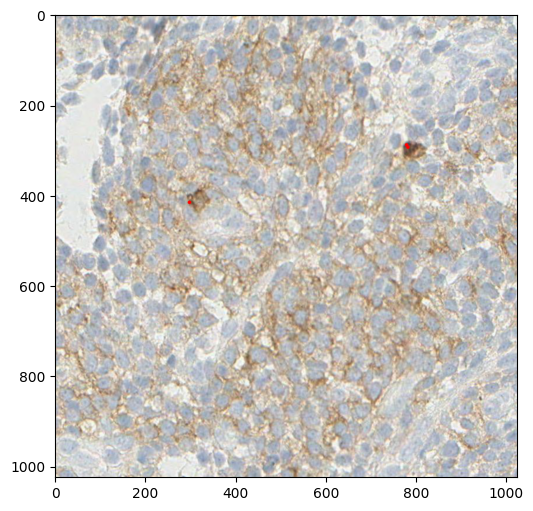

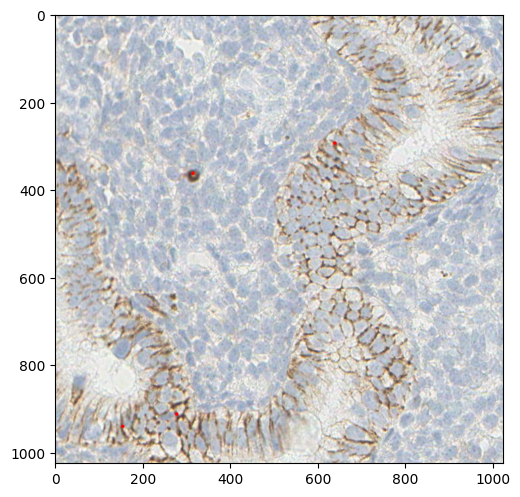

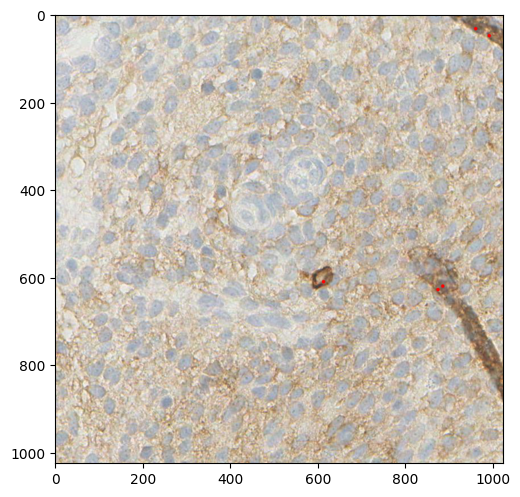

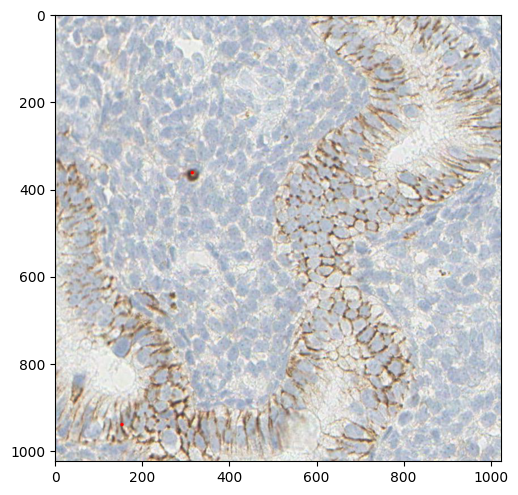

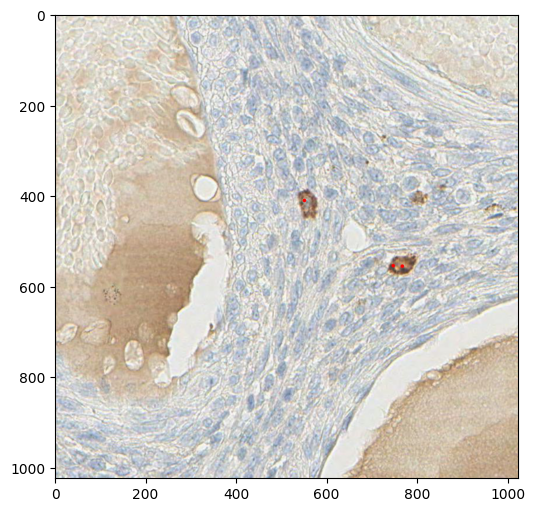

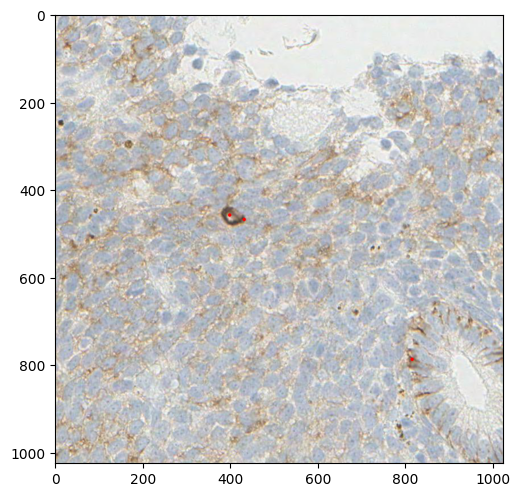

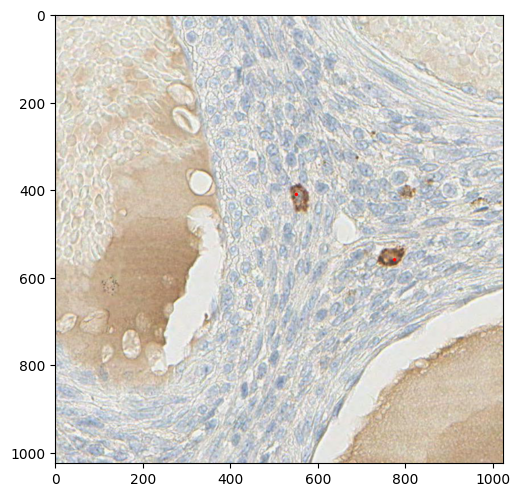

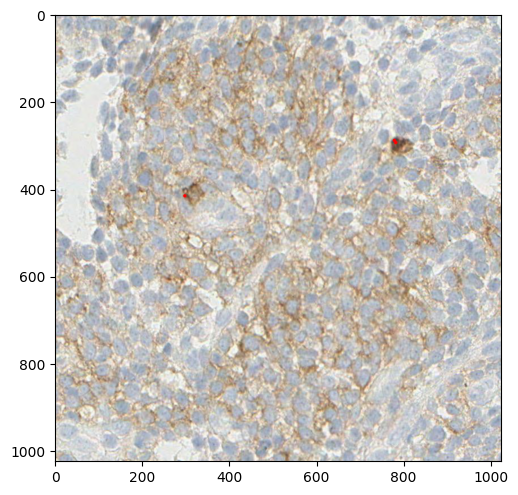

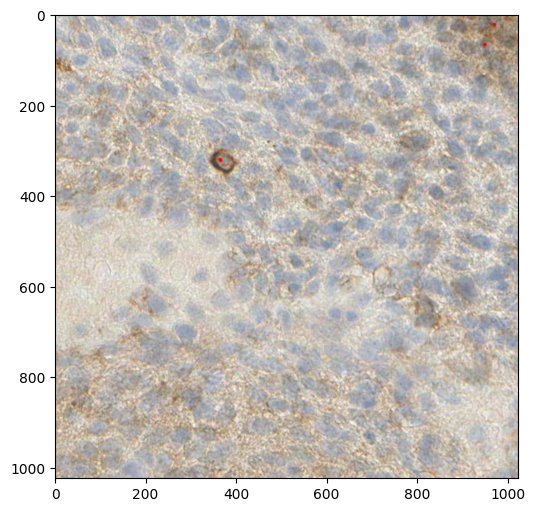

(9, 1024, 1024, 3)


In [34]:
#Download our tiles
tiles_directory_in_str = "/home/alexmak123/test_cappa_koef/plasmatic_tiles_anna/anna_plasmatic_result_algo"
%cd $tiles_directory_in_str
alb_transforms = A.Compose([A.augmentations.Resize(1024, 1024)])
def import_tiles_from_directory_and_convert_them (tiles_directory_in_str):
    directory = os.fsencode(tiles_directory_in_str)
    converted_images = []
    j = 0
    for file in os.listdir(directory):
        j += 1
        filename = os.fsdecode(file)
        if (filename.endswith(".png") or filename.endswith(".jpg")): 
            myTile = np.array(Image.open(filename).convert('RGB'))
            myTile = alb_transforms(image=myTile)["image"]
            converted_images.append(myTile)
            plt.subplot(4, 4, j)
            plt.imshow(myTile)
            plt.show()
            continue
        else:
            continue
    return np.array(converted_images)

converted_images = import_tiles_from_directory_and_convert_them (tiles_directory_in_str)
print(converted_images.shape)